In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image

In [64]:
# Load images
I1 = (Image.open('i1.jpg'))
i1 = np.asarray(I1.convert(mode='L'))
I2 = (Image.open('i2.jpg'))
i2 = np.asarray(I2.convert(mode='L'))


In [47]:
# helper functions


# First define 1 dimensional helper gaussian
def oneDimGaussian(x,stdDev):
    return (1/(stdDev*(2*np.pi)**0.5))* np.e**(-(x**2)/(2*stdDev**2))

def getGaussBlur(stdDev):
    # generate size of kernel
    # from centre to 3 stdDevs out the gaussian is approx zero, hence for a = 2*(3*stdDev), size is a x a (a should be odd)
    sizeLength = 2*(3*stdDev) + 1
    ker = np.arange(start=-(sizeLength//2),stop=sizeLength//2+1,step=1,dtype=float)
    # assuming the gaussian is centred (mean of (0,0))
    gz = np.array(
        [oneDimGaussian(x,stdDev) for x in ker]
    )
    # reshape to not have trailing ',' can get errors
    if gz.shape != (len(ker),1):
        gz = gz.reshape((len(ker),1))
        assert(gz.shape == (len(ker),1))
    
    # compute outer product to get matrix of shape sideLength x sideLength
    kernel = np.outer(gz,gz.T)
    kernel = kernel/kernel.max()

    # Testing
    # plt.imshow(kernel,interpolation=None,cmap='gray')
    # plt.show()

    return kernel

def convolution(kernel,im):
    # get bounds
    imWidth = im.shape[1]; imHeight = im.shape[0]
    kernelWidth = kernel.shape[1]; kernelHeight = kernel.shape[0]
    # place holder for gradient vals
    conv = np.zeros((imHeight,imWidth))

    # need to add rows and cols to image in case the mask goes off of the real image
    # need to +/- by 1 because dim of kernel are odd
    extraCols = int((kernelWidth+1)/2) # along horizontal <---->
    extraRows = int((kernelHeight+1)/2) # along vertical

    imToConv = np.zeros((imHeight + 2*extraCols,imWidth + 2*extraRows))

    # same image with zeros surrounding it
    for col in range(extraCols,imWidth + extraCols): # along x axis
        for row in range(extraRows,imHeight + extraRows): # along y axis
            # print(col,row)
            imToConv[row,col] = im[row-extraRows,col-extraCols]
    # do masking
    for row in range(0,imHeight,1):
        for col in range(0,imWidth,1):
            imgVals = imToConv[row:row+kernelHeight,col:col+kernelWidth]
            conv[row][col] = (np.multiply(kernel,imgVals)).sum()
    # weighted avg
    conv = conv/(kernelWidth*kernelHeight)
    return conv
    

gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


In [69]:
def findCorners(stdDev,imagePath,threshold=150):

    # loading image data
    I = Image.open(imagePath)
    img = np.asarray(I.convert(mode='L'))

    gradX = convolution(gx,img); gradY = convolution(gy,img)
    gradXX = gradX**2; gradYY = gradY**2; gradXY = gradX*gradY

    # getting gauss kernel to average data
    gaussKernel = getGaussBlur(stdDev)
    wgx = convolution(gaussKernel,gradXX); wgy = convolution(gaussKernel,gradYY); wgxy = convolution(gaussKernel,gradXY)
    
    # find eigen values
    eig1, eig2 = [],[]
    cornerRow, cornerCol = [],[]
    for i in range(gradXX.shape[0]):
        for j in range(gradXX.shape[1]):
            M = np.array([[wgx[i,j],wgxy[i,j]],[wgxy[i,j],wgy[i,j]]])
            eigVals = np.linalg.eigvals(M)
            eig1 += [eigVals[0]]
            eig2 += [eigVals[1]]

            minEig = min(eigVals[0],eigVals[1])

            if minEig >= threshold:
                cornerRow += [i]
                cornerCol += [j]
    # show scatter
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(eig1,eig2)

    fig2, ax2 = plt.subplots(1)
    ax2.imshow(I)
    ax2.scatter(cornerCol,cornerRow,c='#FF0000')

    plt.show() 

    


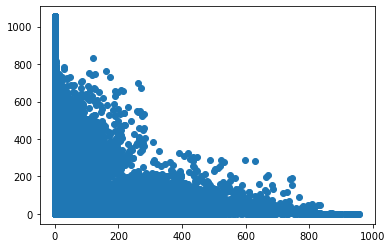

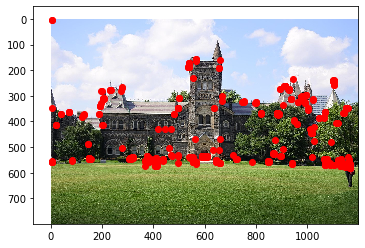

In [71]:
findCorners(1,'./i2.jpg')

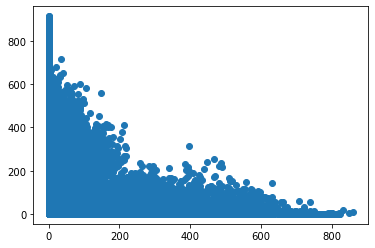

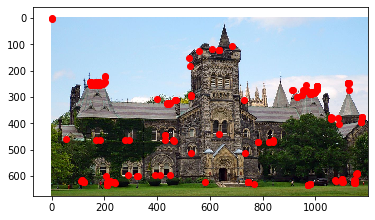

In [72]:
findCorners(1,'./i1.jpg')

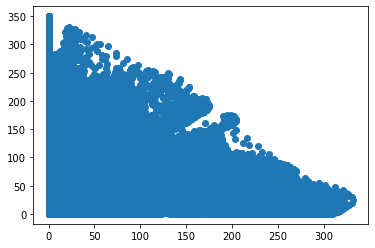

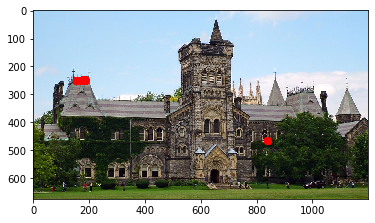

In [73]:
findCorners(4,'./i1.jpg')

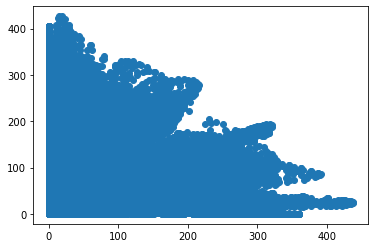

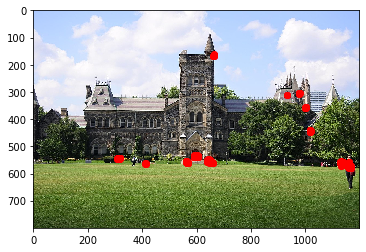

In [75]:
findCorners(4,'./i2.jpg')

In [ ]:
"""
3.4)
    When choosing a standard deviation significantly larger (4) than the initial value chosen (1), there were much less corners detected, given that the same threshold value was used: Meaning that fewer eigenvalues were larger than the provided theshold. Based on the plot of the two eigenvalues, the values of the eigenvalues shrunk significantly and the plot also became more dense/uniform to form a triangular shape. This is because the size of the kernel became much larger and smoothed the image by a greater factor; i.e., to the point where sharp corners became rounded edges. 

"""